# ИМПОРТЫ И ЗАГРУЗКА ДАННЫХ

In [768]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import OneHotEncoder

In [769]:
# Загрузить данные из Google Sheets в Pandas DataFrame
url = 'https://docs.google.com/spreadsheets/d/12o1iofQx6V-UhInjUjLjpKxx3Z8ve8EGxnQtzNioIv4/export?format=csv'
df = pd.read_csv(url)

In [770]:
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [771]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [772]:
df.dtypes

MONTH                int64
SERVICE_CATEGORY    object
CLAIM_SPECIALTY     object
PAYER               object
PAID_AMOUNT          int64
dtype: object

In [773]:
# Проверка на наличие пропущенных значений
df.isnull().sum()

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64

In [774]:
# Проверка на наличие дубликатов
df.duplicated().sum()

0

# EDA

### MONTH

In [775]:
df['MONTH'].value_counts().sort_index()

201801    1712
201802    1664
201803    1723
201804    1714
201805    1759
201806    1745
201807    1706
201808    1775
201809    1767
201810    1748
201811    1747
201812    1718
201900      11
201901    1790
201902    1751
201903    1769
201904    1767
201905    1823
201906    1746
201907    1877
201908    1828
201909    1774
201910    1863
201911    1723
201912    1772
202001    1782
202002    1711
202003    1769
202004    1539
202005    1668
202006    1344
202007      67
Name: MONTH, dtype: int64

удалим июль 2020 года (мало данных) и несуществующую дату 201900

In [776]:
df = df[df['MONTH'].isin([201900, 202007]) == False]

In [777]:
df.shape

(52074, 5)

преобразуем в дату

In [778]:
df['MONTH'] = df['MONTH'].astype(str)
df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y%m')

In [779]:
df['MONTH'].value_counts().sort_index()

2018-01-01    1712
2018-02-01    1664
2018-03-01    1723
2018-04-01    1714
2018-05-01    1759
2018-06-01    1745
2018-07-01    1706
2018-08-01    1775
2018-09-01    1767
2018-10-01    1748
2018-11-01    1747
2018-12-01    1718
2019-01-01    1790
2019-02-01    1751
2019-03-01    1769
2019-04-01    1767
2019-05-01    1823
2019-06-01    1746
2019-07-01    1877
2019-08-01    1828
2019-09-01    1774
2019-10-01    1863
2019-11-01    1723
2019-12-01    1772
2020-01-01    1782
2020-02-01    1711
2020-03-01    1769
2020-04-01    1539
2020-05-01    1668
2020-06-01    1344
Name: MONTH, dtype: int64

сделаем фичу по полугодию для дальнейшей группировки

In [780]:
df['HALF_YEAR'] = df['MONTH'].apply(lambda x: datetime(x.year, 6,1) if x.month <=6 else datetime(x.year, 12,1))

In [781]:
df['HALF_YEAR'].value_counts().sort_index()

2018-06-01    10317
2018-12-01    10461
2019-06-01    10646
2019-12-01    10837
2020-06-01     9813
Name: HALF_YEAR, dtype: int64

### SERVICE_CATEGORY

In [782]:
df['SERVICE_CATEGORY'].value_counts().sort_index()

ASCServices            2639
AncillaryFFS           9682
ERServices             3690
InpatientServices      9413
OutpatientServices     7572
PCPEncounter           1221
PCPFFS                 1401
SNFServices            2497
SpecialistFFS          1684
SpecialistsFFS        12275
Name: SERVICE_CATEGORY, dtype: int64

SpecialistsFFS приравняем с SpecialistFFS, т.к. по сути - одно и то же

In [783]:
df['SERVICE_CATEGORY'] = df['SERVICE_CATEGORY'].apply(lambda x: 'SpecialistFFS' if x == 'SpecialistsFFS' else x)

In [784]:
df['SERVICE_CATEGORY'].value_counts().sort_index()

ASCServices            2639
AncillaryFFS           9682
ERServices             3690
InpatientServices      9413
OutpatientServices     7572
PCPEncounter           1221
PCPFFS                 1401
SNFServices            2497
SpecialistFFS         13959
Name: SERVICE_CATEGORY, dtype: int64

### CLAIM_SPECIALTY

In [785]:
df['CLAIM_SPECIALTY'].isnull().sum()

251

In [786]:
df.head(5)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR
0,2018-01-01,AncillaryFFS,NaN,Payer F,4281,2018-06-01
1,2018-01-01,AncillaryFFS,NaN,Payer H,2221,2018-06-01
2,2018-01-01,AncillaryFFS,NaN,Payer O,3937,2018-06-01
3,2018-01-01,AncillaryFFS,NaN,Payer W,268,2018-06-01
4,2018-01-01,AncillaryFFS,ACH,Payer W,151,2018-06-01


In [787]:
df.CLAIM_SPECIALTY.unique().shape

(906,)

предобработаем специальности для более точной аналитики (приведем в нижний регистр, сгруппируем похожие,
обьединим малочисленные специальности в other)
Возможно маппинг будет не до конца некорректен, т.к. необходимо небольшое погружение в предметную область + необходимо взаимодействие с заказчиком для уточенния правильного категорирования специализаций

In [788]:
df['CLAIM_SPECIALTY'] = df['CLAIM_SPECIALTY'].apply(lambda x: str(x).lower() if x else str(x))

In [789]:
def speciality(x):
    if 'assistant' in x or 'nursing' in x or 'nurs' in x:
        return 'assistant_nurse'    
    elif 'family practice' in x:
        return 'family practice'
    elif 'radiology' in x or 'nuclear' in x or 'x-ray' in x:
        return 'radiology'
    elif 'emergency' in x or 'ambulance' in x or 'critical care' in x or 'urgent care' in x:
        return 'emergency'
    elif 'general practice' in x:
        return 'general practice'
    elif 'pathology' in x:
        return 'pathology'
    elif 'gastroenterology' in x:
        return 'gastroenterology'
    elif 'surg' in x and 'plastic' not in x:
        return 'surgery'
    elif 'surgery' in x and 'plastic' in x:
        return 'plastic surgery'
    elif 'cardiology' in x or 'cardiac' in x:
        return 'cardiology'
    elif 'anesth' in x and 'nurs' not in x:
        return 'anesthesiology'
    elif 'neurology' in x:
        return 'neurology'
    elif 'urology' in x:
        return 'urology'
    elif 'nephrology' in x:
        return 'nephrology'
    elif 'podiatry' in x:
        return 'podiatry'
    elif 'pain management' in x:
        return 'pain management'
    elif 'hospital' in x:
        return 'hospital'
    elif 'hematology' in x:
        return 'hematology'
    elif 'oncology' in x:
        return 'oncology'
    elif 'endocrinology' in x:
        return 'endocrinology'
    elif 'pulmonary' in x:
        return 'pulmonary'
    elif 'lab' in x:
        return 'laboratory'
    elif 'derma' in x:
        return 'dermatology'
    elif 'infecti' in x:
        return 'infectious'
    elif 'rehab' in x:
        return 'rehab'
    elif 'gynecology' in x:
        return 'gynecology'
    elif 'psychiatry' in x:
        return 'psychiatry'
    elif 'geriatrics' in x:
        return 'geriatrics'
    elif 'osteo' in x:
        return 'osteopath'
    elif 'opt' in x or 'ophth' in x or 'visio' in x:
        return 'opthalmology'
    elif 'physical therapy' in x:
        return 'physical therapy'
    elif 'rheumatology' in x:
        return 'rheumatology'
    elif 'pediatrics' in x:
        return 'pediatrics'
    elif 'pediatrics' in x:
        return 'pediatrics'
    elif 'internal medicine' in x:
        return 'internal medicine'
    elif 'podiatrist' in x or 'orthoped' in x:
        return 'podiatrist'
    elif 'psychology' in x:
        return 'psychology'
    else:
        return 'other'

In [790]:
df['CLAIM_SPECIALTY_GRP'] = df['CLAIM_SPECIALTY'].apply(speciality)

In [791]:
df.CLAIM_SPECIALTY.unique().shape

(795,)

In [792]:
df.groupby(['CLAIM_SPECIALTY_GRP', 'CLAIM_SPECIALTY'])['PAYER'].count().to_excel('test.xlsx')

### PAYER

In [793]:
df['PAYER'].value_counts().sort_index()

Payer B     3631
Payer CA    8681
Payer CO    3677
Payer F     9012
Payer H     2291
Payer O     6277
Payer S     4189
Payer UL     685
Payer UN    6526
Payer W     7105
Name: PAYER, dtype: int64

In [794]:
df.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other
1,2018-01-01,AncillaryFFS,nan,Payer H,2221,2018-06-01,other
2,2018-01-01,AncillaryFFS,nan,Payer O,3937,2018-06-01,other
3,2018-01-01,AncillaryFFS,nan,Payer W,268,2018-06-01,other
4,2018-01-01,AncillaryFFS,ach,Payer W,151,2018-06-01,other


### PAID_AMOUNT

In [795]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52074 entries, 0 to 52084
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                52074 non-null  datetime64[ns]
 1   SERVICE_CATEGORY     52074 non-null  object        
 2   CLAIM_SPECIALTY      52074 non-null  object        
 3   PAYER                52074 non-null  object        
 4   PAID_AMOUNT          52074 non-null  int64         
 5   HALF_YEAR            52074 non-null  datetime64[ns]
 6   CLAIM_SPECIALTY_GRP  52074 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 3.2+ MB


<Axes: xlabel='MONTH'>

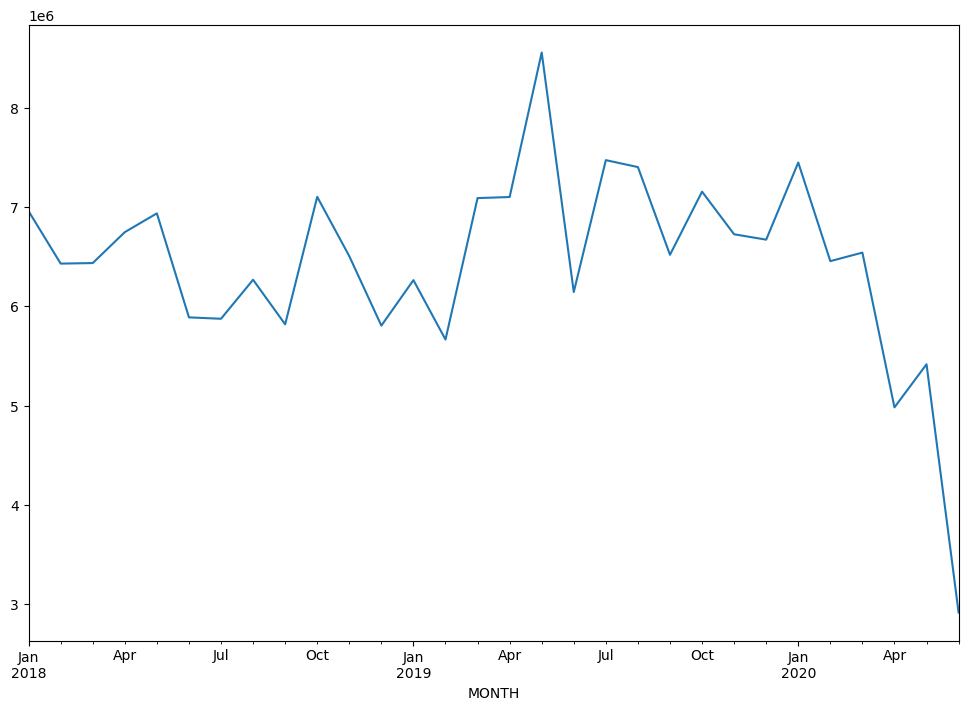

In [797]:
df.groupby('MONTH')['PAID_AMOUNT'].sum().plot()

#### Вывод: За всю историю наблюдений по выплатам от страховых компаний видим пик выплат в июне 2019 года, и сильный спад по выплатам начиная с апреля 2020.

### Аналитика по выплатам по компаниям + нулевых выплат и отрицательных (возвраты)

In [798]:
# создадим сводный датасет в котором сделаем аналитику по выпдатам
total_paid = df[df['PAID_AMOUNT'] > 0 ].groupby('HALF_YEAR')['PAID_AMOUNT'].sum().reset_index()
total_paid.columns = ['HALF_YEAR','TOTAL_PAID']
total_null_paid = df[df['PAID_AMOUNT'] == 0 ].groupby('HALF_YEAR')['PAID_AMOUNT'].count().reset_index()
total_null_paid.columns = ['HALF_YEAR','TOTAL_NULL_COUNT']
total_refund_paid = df[df['PAID_AMOUNT'] < 0 ].groupby('HALF_YEAR')['PAID_AMOUNT'].sum().reset_index()
total_refund_paid.columns = ['HALF_YEAR','TOTAL_REFUND_PAID']

In [799]:
df_grouped = df[df['PAID_AMOUNT'] > 0 ].groupby(['PAYER', 'HALF_YEAR'])['PAID_AMOUNT'].agg(['sum', 'mean']).reset_index()

In [800]:
df_grouped_null  = df[df['PAID_AMOUNT']  == 0 ].groupby(['PAYER', 'HALF_YEAR'])['PAID_AMOUNT'].count().reset_index()
df_grouped_null.columns = ['PAYER','HALF_YEAR','COUNT_NULL']

In [801]:
df_grouped_refund  = df[df['PAID_AMOUNT']  < 0 ].groupby(['PAYER', 'HALF_YEAR'])['PAID_AMOUNT'].sum().reset_index()
df_grouped_refund.columns = ['PAYER','HALF_YEAR','PAID_REFUND']

In [802]:
df_paid = df_grouped.merge(df_grouped_null, on= ['PAYER', 'HALF_YEAR'],how='outer')
df_paid = df_paid.merge(df_grouped_refund, on= ['PAYER', 'HALF_YEAR'],how='outer')

df_paid = df_paid.merge(total_paid, on = 'HALF_YEAR', how='outer')
df_paid = df_paid.merge(total_null_paid, on= 'HALF_YEAR', how='outer')
df_paid = df_paid.merge(total_refund_paid, on= 'HALF_YEAR', how='outer')

In [803]:
df_paid['percent_amount'] = (df_paid['sum'] / df_paid['TOTAL_PAID'] ) * 100
df_paid['percent_null'] = (df_paid['COUNT_NULL'] / df_paid['TOTAL_NULL_COUNT'] ) * 100
df_paid['percent_refund'] = (df_paid['PAID_REFUND'] / df_paid['TOTAL_REFUND_PAID'] ) * 100
df_paid['relat_refund_total'] = (df_paid['PAID_REFUND'] / df_paid['sum'] ) * 100

In [804]:
df_paid = df_paid.fillna(0)

In [805]:
df_paid.head(1)

,PAYER,HALF_YEAR,sum,mean,COUNT_NULL,PAID_REFUND,TOTAL_PAID,TOTAL_NULL_COUNT,TOTAL_REFUND_PAID,percent_amount,percent_null,percent_refund,relat_refund_total
0,Payer B,2018-06-01,366501,660.362162,93.0,-1562.0,39446322,713,-45617,0.929113,13.043478,3.424162,-0.426193


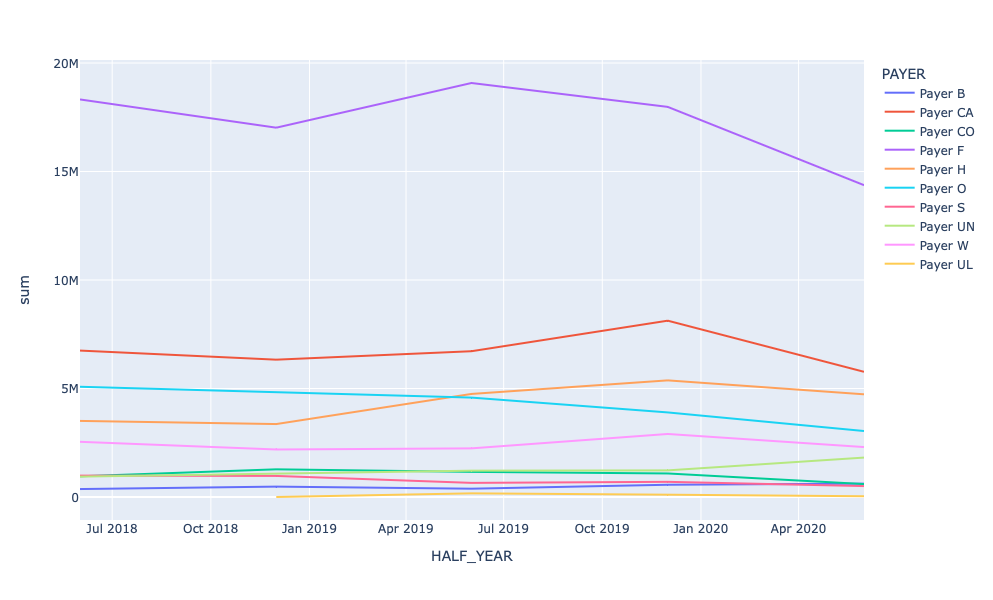

In [806]:
fig = px.line(df_paid, x='HALF_YEAR', y='sum', color='PAYER',
                 width=1000, height=600)
fig.show()

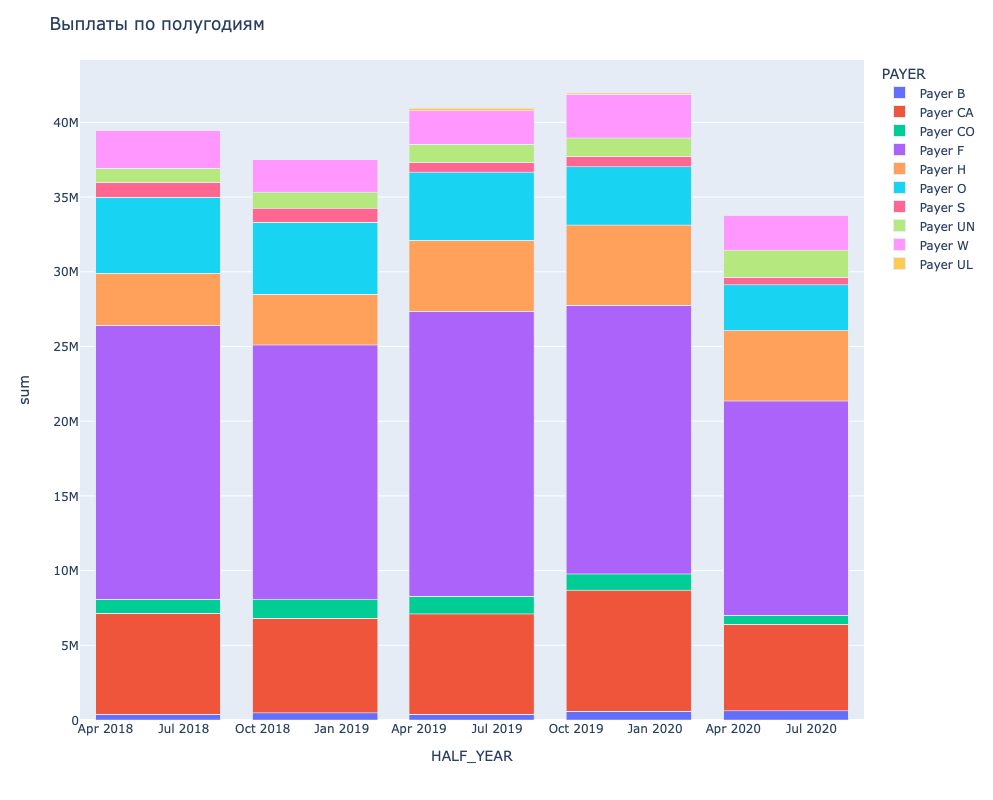

In [807]:
fig = px.bar(df_paid, x='HALF_YEAR', y='sum', color='PAYER', barmode='relative', orientation='v')
fig.update_layout(title='Выплаты по полугодиям')
fig.update_layout(height=800, width=1000)
fig.show()

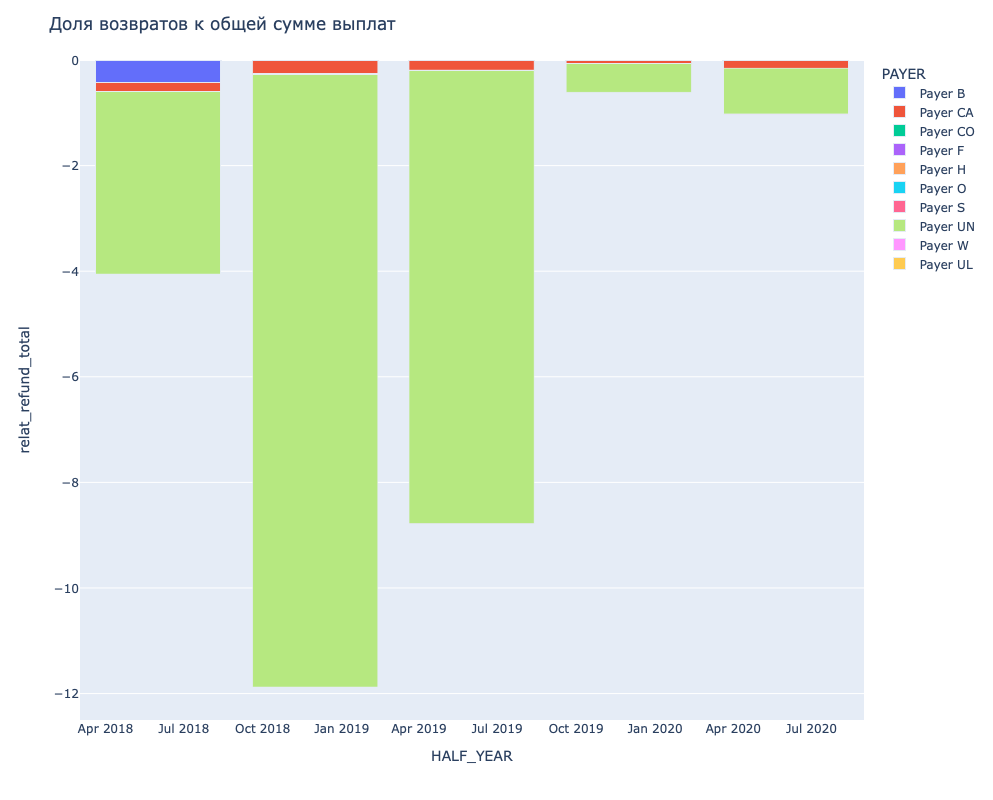

In [808]:
fig = px.bar(df_paid, x='HALF_YEAR', y='relat_refund_total', color='PAYER', barmode='relative', orientation='v')
fig.update_layout(title='Доля возвратов к общей сумме выплат')
fig.update_layout(height=800, width=1000)
fig.show()

### Выводы: во втором полугодии 2018 и в первом 2019ого доля отношение возвратов к выплатам у компании UN составило 12 и 9 % сооответственно, данная компания существенно выделяется по этому показателю от остальных страховщиков.

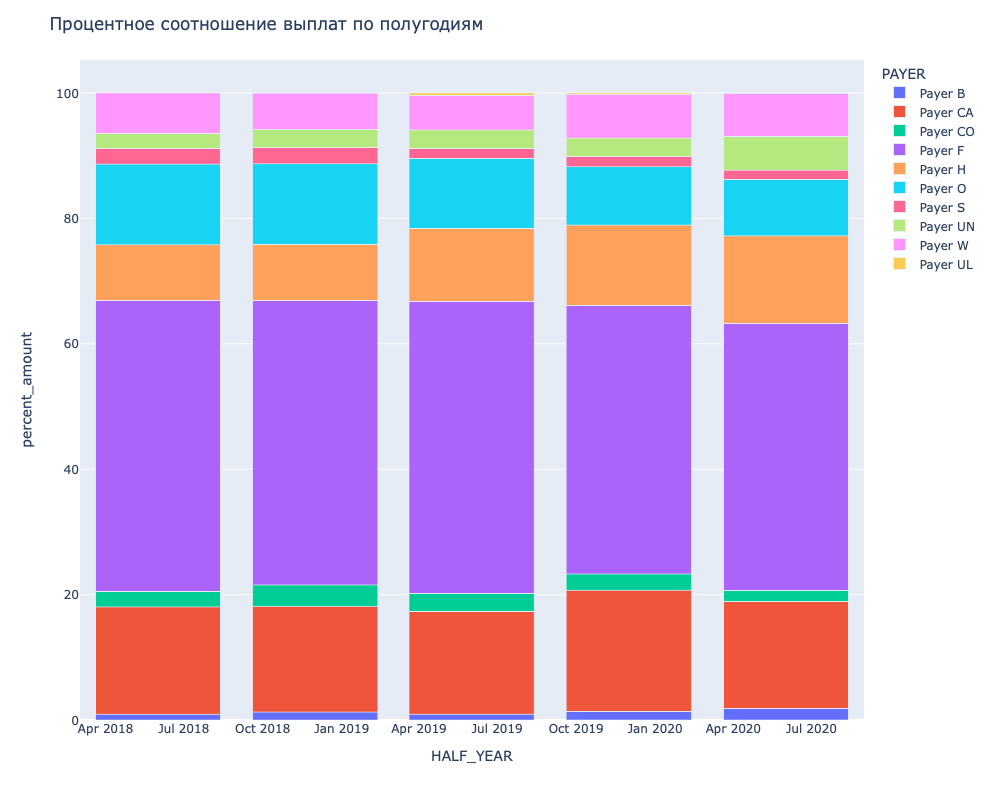

In [809]:
fig = px.bar(df_paid, x='HALF_YEAR', y='percent_amount', color='PAYER', barmode='relative', orientation='v')
fig.update_layout(title='Процентное соотношение выплат по полугодиям')
fig.update_layout(height=800, width=1000)
fig.show()

### Выводы: Крупнейшим страховщиком является Payer B, но с течением времени доля среди остальных страховщиков упала с 46 до 42%. Стоит отметить Payer H, который нарастил долю с 9 % до 14% за весь период наблюдений. Так же за последние пол года наблюдений Payer UN вырос с 3 до 5,5%

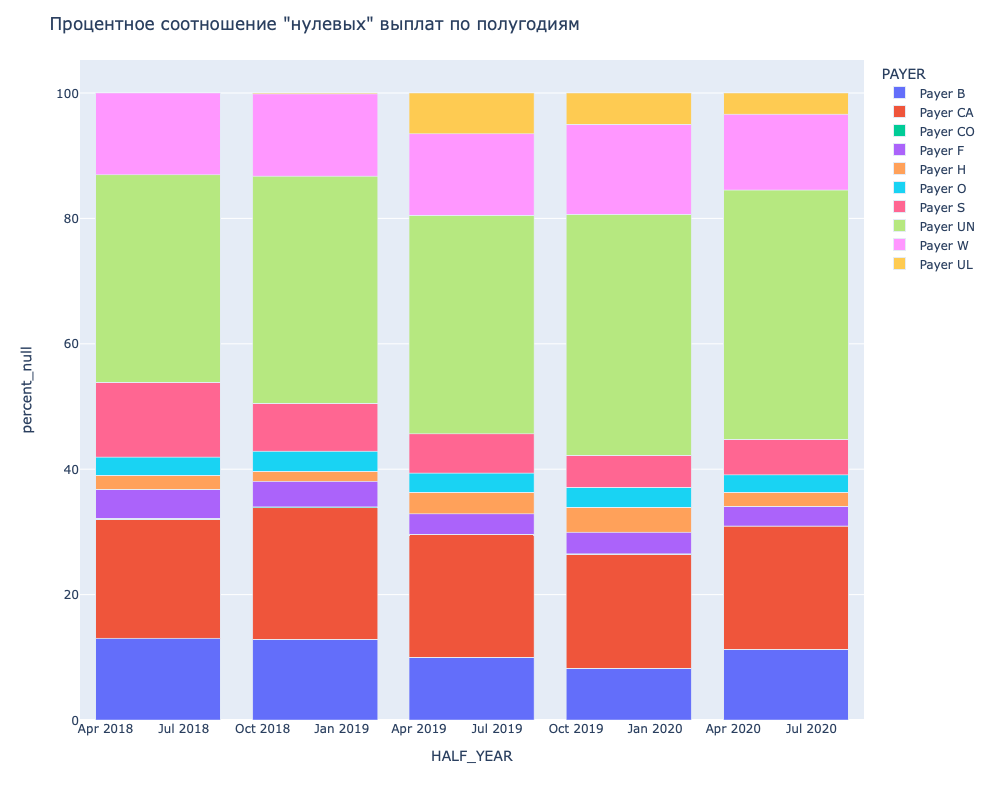

In [810]:
fig = px.bar(df_paid, x='HALF_YEAR', y='percent_null', color='PAYER', barmode='relative', orientation='v')
fig.update_layout(title='Процентное соотношение "нулевых" выплат по полугодиям')
fig.update_layout(height=800, width=1000)
fig.show()

### Выводы: В среднем 33% занимает Payer UN по нулевым выплатам, это возможно качество данных, на 2ом месте - payer CA. Но ниже приведен график по отрицательным выплатам (предположительно возвраты), в них так же лидирует Payer UN, где возвраты составляют от 63 до 88 % от всех возвратов по полугодию). И на 2ом месте по возвратам, как и по нулевым выплатам - Payer CA.

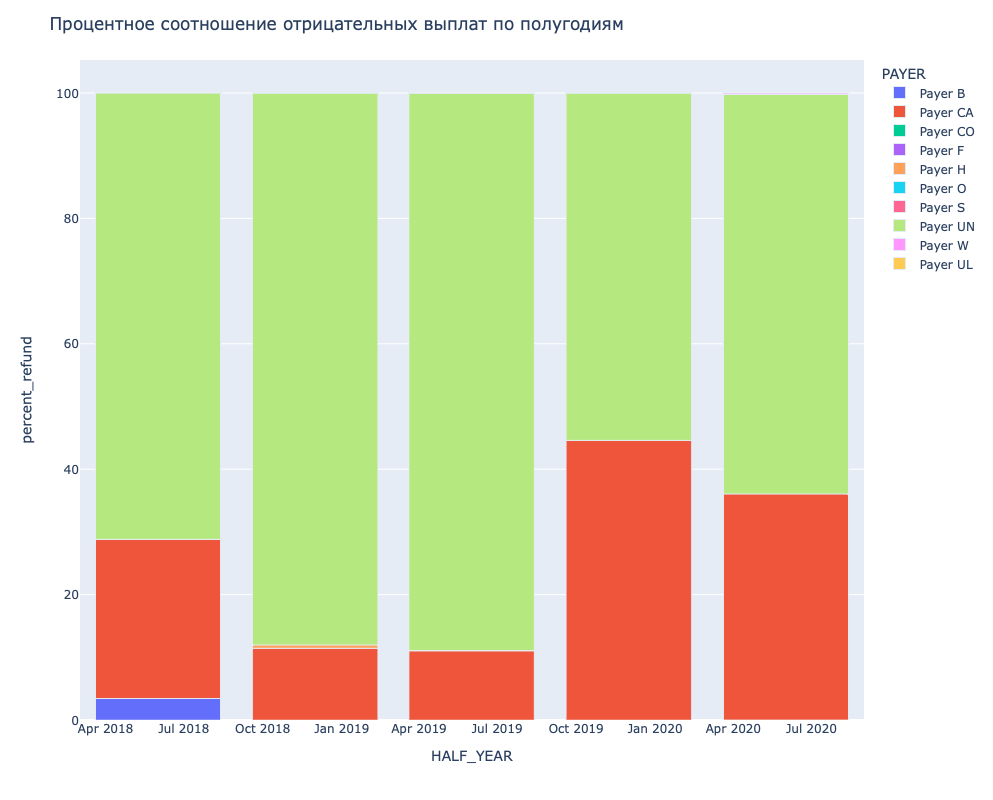

In [811]:
fig = px.bar(df_paid, x='HALF_YEAR', y='percent_refund', color='PAYER', barmode='relative', orientation='v')
fig.update_layout(title='Процентное соотношение отрицательных выплат по полугодиям')
fig.update_layout(height=800, width=1000)
fig.show()

In [812]:
df.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other


### Аналитика по возвратам в разрезе SERVICE_CATEGORY и CLAIM_SPECIALTY_GRP для ТОП-2 страховщиков по отрицательным выплатам

In [813]:
df[(df['PAID_AMOUNT'] < 0)&(df['PAYER'].isin(['Payer CA', 'Payer UN']))].groupby(['PAYER', 'SERVICE_CATEGORY'])['PAID_AMOUNT'].count().reset_index()

,PAYER,SERVICE_CATEGORY,PAID_AMOUNT
0,Payer CA,AncillaryFFS,2
1,Payer CA,PCPEncounter,81
2,Payer UN,AncillaryFFS,223


In [814]:
df[(df['PAID_AMOUNT'] < 0)&(df['PAYER'].isin(['Payer CA', 'Payer UN']))].groupby(['PAYER', 'CLAIM_SPECIALTY_GRP'])['PAID_AMOUNT'].count().reset_index().sort_values(by = 'PAID_AMOUNT', ascending = False)

,PAYER,CLAIM_SPECIALTY_GRP,PAID_AMOUNT
19,Payer UN,opthalmology,33
3,Payer CA,internal medicine,29
1,Payer CA,general practice,28
17,Payer UN,internal medicine,21
0,Payer CA,family practice,19
15,Payer UN,hematology,19
28,Payer UN,surgery,18
20,Payer UN,other,18
26,Payer UN,radiology,16
29,Payer UN,urology,11


In [816]:
df.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other


# Anomaly detection

Далее для поиска выбросов и аномалий исключим нулевые выплаты и отрицательные, т.к. по ним анализ закончен.

Т.к. выбросы зависят таких факторов, как вид врачебной деятельности, тип услуги, то поиск аномалий предлагаю производить в зависимости них. Т.к. например выброс в терапии, может быть нормой в хирургии.

Выбросы будем производит по методу 3-х сигм, но т.к. у нас распределение не нормальное, пролагорифмируем его для корректного нахожденеия выбросов


In [817]:
df = df[df['PAID_AMOUNT'] > 0].reset_index(drop=True)

/var/folders/36/tcpthx013zjb5h_v448f323r0000gn/T/ipykernel_15266/2013877781.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='PAID_AMOUNT', ylabel='Density'>

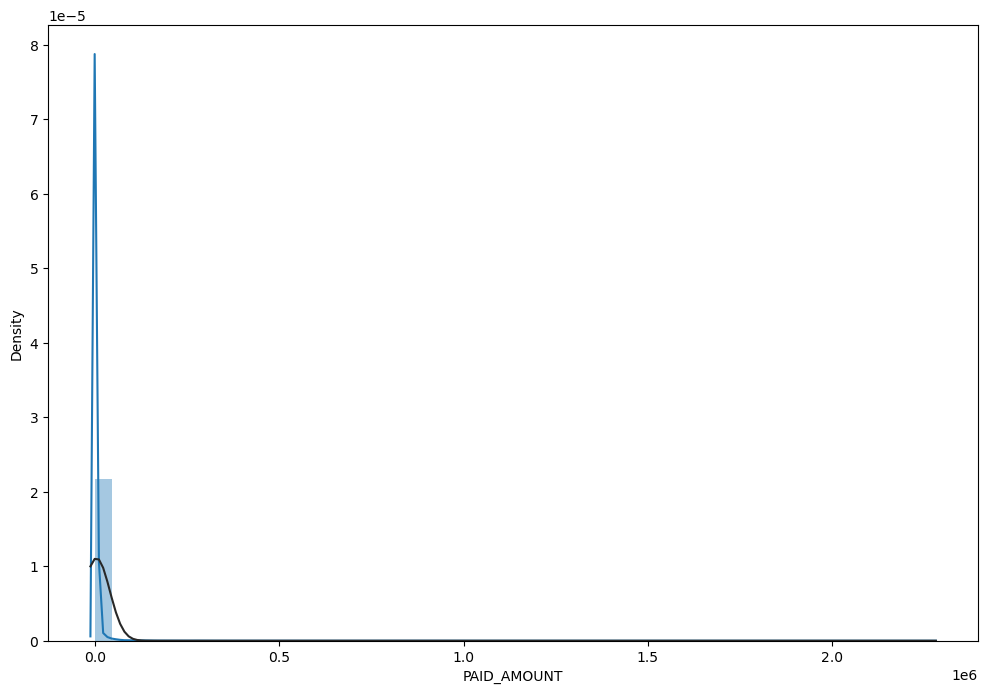

In [818]:
sns.distplot(df['PAID_AMOUNT'], fit=norm)

/var/folders/36/tcpthx013zjb5h_v448f323r0000gn/T/ipykernel_15266/1952602532.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='PAID_AMOUNT', ylabel='Density'>

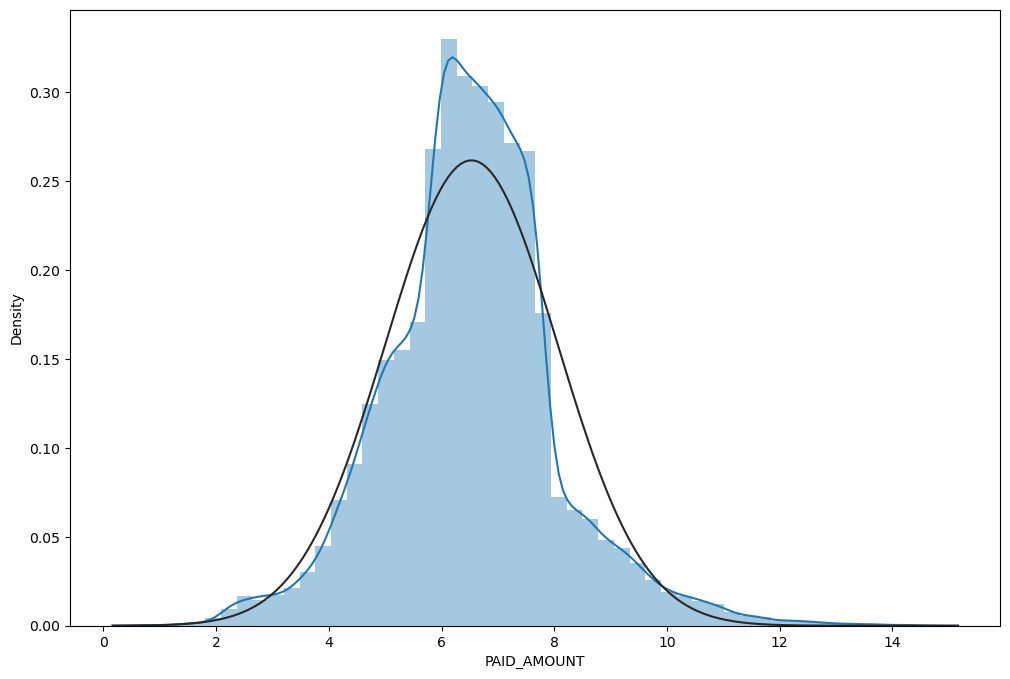

In [819]:
sns.distplot(np.log(df['PAID_AMOUNT']+1), fit=norm)

<Axes: >

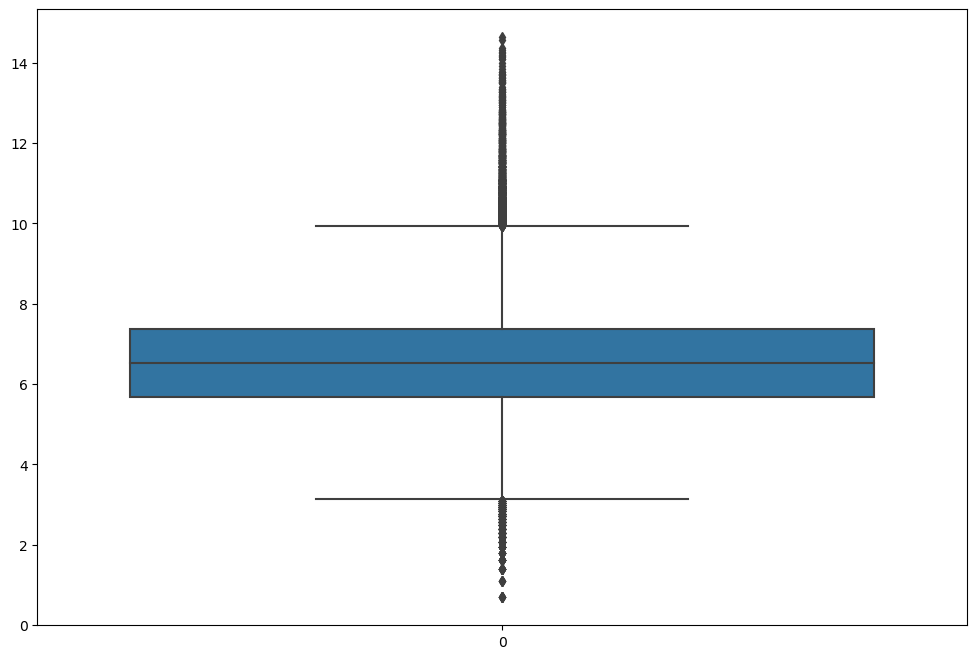

In [820]:
sns.boxplot(np.log(df['PAID_AMOUNT']+1))

In [821]:
df.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other


In [822]:
df['PAID_AMOUNT_LOG'] = np.log(df['PAID_AMOUNT']+1)

In [823]:
df.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP,PAID_AMOUNT_LOG
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other,8.362175


In [824]:
df_grp = df.groupby(['SERVICE_CATEGORY', 'CLAIM_SPECIALTY_GRP'])['PAID_AMOUNT_LOG'].agg(['sum', 'mean', 'std']).reset_index()
df_grp['up_bound'] = df_grp['mean'] + 3 * df_grp['std']
df_grp['low_bound'] = df_grp['mean'] - 3 * df_grp['std']

In [825]:
df_new = df.merge(df_grp, on = ['SERVICE_CATEGORY', 'CLAIM_SPECIALTY_GRP'], how='outer')

In [826]:
df_new.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,HALF_YEAR,CLAIM_SPECIALTY_GRP,PAID_AMOUNT_LOG,sum,mean,std,up_bound,low_bound
0,2018-01-01,AncillaryFFS,nan,Payer F,4281,2018-06-01,other,8.362175,18377.710656,6.754028,1.645389,11.690196,1.81786


In [827]:
df_new[['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'PAID_AMOUNT', 'CLAIM_SPECIALTY_GRP']].to_excel('payment.xlsx')

In [828]:
df_new['is_lower_outlier'] = df_new.apply(lambda x: 1 if x['PAID_AMOUNT_LOG'] < x['low_bound'] else 0, axis = 1)
df_new['is_upper_outlier'] = df_new.apply(lambda x: 1 if x['PAID_AMOUNT_LOG'] > x['up_bound'] else 0, axis = 1)

### Вывод: выбросы по нижней границе содержат 154 строк, что незначительно от общего числа выплат ()

In [829]:
df1 = df_new.groupby(['HALF_YEAR', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY_GRP'])['PAID_AMOUNT'].sum().reset_index()
df_out = df_new[df_new['is_upper_outlier'] == 1].groupby(['PAYER','HALF_YEAR', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY_GRP'])['PAID_AMOUNT'].sum().reset_index()

In [830]:
df_out.columns = ['PAYER','HALF_YEAR', 'SERVICE_CATEGORY','CLAIM_SPECIALTY_GRP','UPPER_OUTLIERS']

In [831]:
df_out = df_out.merge(df1, on = ['HALF_YEAR', 'SERVICE_CATEGORY','CLAIM_SPECIALTY_GRP'], how = 'outer')

In [832]:
df_out['percent_outliers'] = df_out['UPPER_OUTLIERS']/df_out['PAID_AMOUNT']*100

In [833]:
df_out[df_out['percent_outliers'] > 0].sort_values(by = 'percent_outliers', ascending = False)

,PAYER,HALF_YEAR,SERVICE_CATEGORY,CLAIM_SPECIALTY_GRP,UPPER_OUTLIERS,PAID_AMOUNT,percent_outliers
8,Payer F,2019-06-01,InpatientServices,other,7757673.0,9677078,80.165449
11,Payer F,2019-12-01,InpatientServices,other,6795904.0,8669224,78.391146
14,Payer F,2020-06-01,InpatientServices,other,5029680.0,6603496,76.166927
1,Payer F,2018-06-01,InpatientServices,other,8153070.0,10808941,75.428944
4,Payer F,2018-12-01,InpatientServices,other,5975374.0,8206056,72.816637
22,Payer S,2018-06-01,InpatientServices,emergency,234789.0,328336,71.508759
23,Payer S,2018-12-01,InpatientServices,emergency,238095.0,352938,67.460857
10,Payer F,2019-06-01,OutpatientServices,other,1599293.0,2481748,64.442200
19,Payer H,2019-12-01,SNFServices,hospital,16807.0,33115,50.753435
13,Payer F,2019-12-01,OutpatientServices,other,931708.0,2011145,46.327241


### Выводы по аномалиям. Из вышеуказанной таблицы можно сделать выводы, что в основном высокие затраты на выплты от страховых компаний приходятся на вид медицинских услуг - прочее (ранее категорировалось).
### Так, например за 1 квартал 2019 года компания F в категории InpatientServices платы по прочим врачебным специализациям составили 80% от аналогичного периода по всем остальным компаниям в этой же категории, аналогичная ситуация во 2-ом квартале 2019 и 1ом 2020 года.

# Попытка прогноза на пол-года. Попробуем спрогнозировать цену на 2 квартал 2020 года. Примением SARIMAX

In [834]:
def plot_data(df):
    df.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.show()

In [835]:
url = 'https://docs.google.com/spreadsheets/d/12o1iofQx6V-UhInjUjLjpKxx3Z8ve8EGxnQtzNioIv4/export?format=csv'
data_series = pd.read_csv(url)

In [836]:
data_series = data_series[data_series['MONTH'].isin([201900, 202007]) == False]
data_series['MONTH'] = data_series['MONTH'].astype(str)
data_series['MONTH'] = pd.to_datetime(data_series['MONTH'], format='%Y%m')

In [837]:
data_series.head(1)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,4281


<Axes: xlabel='MONTH'>

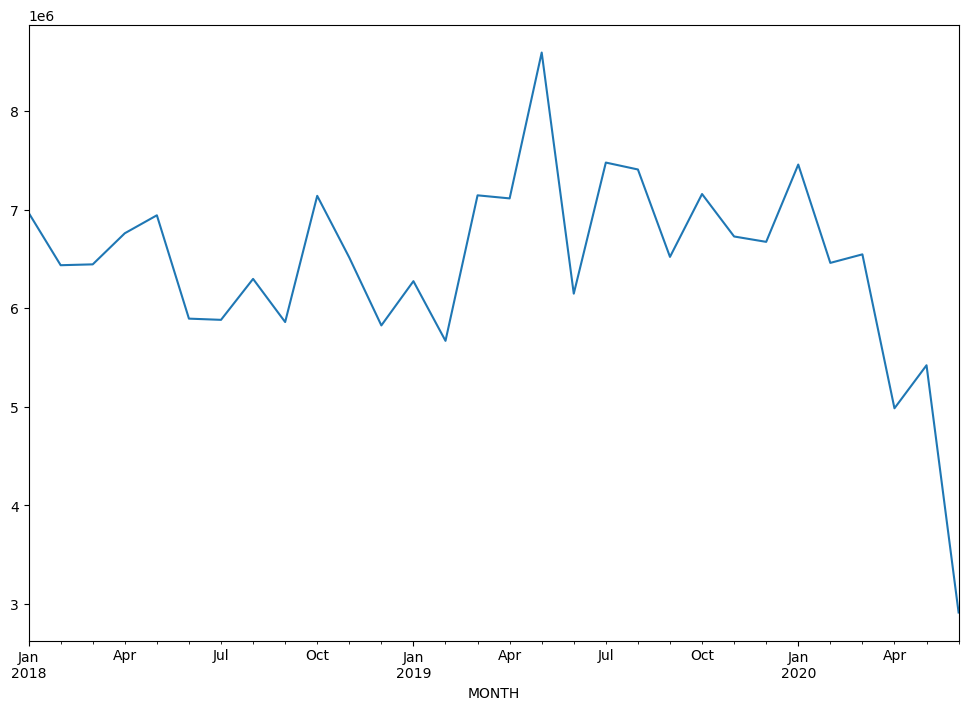

In [838]:
df.groupby('MONTH')['PAID_AMOUNT'].sum().plot()

In [839]:
data_series = data_series.groupby('MONTH')['PAID_AMOUNT'].sum().reset_index()

In [840]:
data_series = data_series.set_index('MONTH')

In [841]:
data_series

,PAID_AMOUNT
MONTH,
2018-01-01,6959445
2018-02-01,6430877
2018-03-01,6436167
2018-04-01,6748037
2018-05-01,6937332
2018-06-01,5888847
2018-07-01,5874723
2018-08-01,6268040
2018-09-01,5818710


In [842]:
# Обучение модели
model = SARIMAX(data_series, order=(6,1,1), seasonal_order=(1,0,0,12), freq='MS')
results = model.fit()

# Прогнозирование на 2ое полугодие 2020
forecast = results.get_forecast(steps=6)
forecast_ci = forecast.conf_int()

# Вывод результатов
print(forecast.predicted_mean)

/Users/viktoriakalasnikova/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54806D+01    |proj g|=  3.53557D-01

At iterate    5    f=  1.46145D+01    |proj g|=  1.91871D-01

At iterate   10    f=  1.45942D+01    |proj g|=  6.67546D-03

At iterate   15    f=  1.45910D+01    |proj g|=  8.21265D-02

At iterate   20    f=  1.45842D+01    |proj g|=  4.14871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     23     28      1     0     0   2.852D-05   1.458D+01
  F =   14.584236990351368     

CONVERG

### Выводы: Ожидаемая прибыль на 2-ое полугодие 2020 - от 3,5 до 4 млн в месяц, если параметрах модели задать период 6 месяцев - для прогнозирование следующего значения